# A simple RXTE spectral extraction example

Here we just show how to get a list of RXTE observations of a given source, construct a file list to the standard products, and extract spectra in physical units using PyXspec.

In [1]:
import sys,os,glob
import pyvo as vo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext wurlitzer # captures Xspec output
import astropy.io.fits as fits
import xspec
xspec.Xset.allowPrompting = False 
os.environ['HEADASNOQUERY']="1"

First query the HEASARC for its catalogs related to XTE.  For more on using PyVO to find observations, see [NAVO's collection of notebook tutorials](https://nasa-navo.github.io/navo-workshop/).  

In [2]:
#  First query the Registry to get the HEASARC TAP service.
tap_services=vo.regsearch(servicetype='table',keywords=['heasarc'])
#  Then query that service for the names of the tables it serves.
heasarc_tables=tap_services[0].service.tables

for tablename in heasarc_tables.keys():
    if "xte" in tablename:  
        print(" {:20s} {}".format(tablename,heasarc_tables[tablename].description))
 

 xteao                XTE Proposal Info & Abstracts
 xteasmlong           XTE All-Sky Monitor Long-Term Observed Sources
 xteassagn            XTE All-Sky Slew Survey AGN Catalog
 xteasscat            XTE All-Sky Slew Survey Catalog
 xteindex             XTE Target Index Catalog
 xtemaster            XTE Master Catalog
 xtemlcat             XTE Mission-Long Source Catalog
 xteslew              XTE Archived Public Slew Data


Query the xtemaster catalog for observations of Eta Car

In [3]:
# Get the coordinate for Eta Car
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("eta car")
query="""SELECT target_name, cycle, prnb, obsid, time, exposure, ra, dec 
    FROM public.xtemaster as cat 
    where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and 
    cat.exposure > 0 order by cat.time
    """.format(pos.ra.deg, pos.dec.deg)
results=tap_services[0].search(query).to_table()
results

target_name,cycle,prnb,obsid,time,exposure,ra,dec
,,,,mjd,s,deg,deg
object,int16,int32,object,float64,float64,float64,float64
ETA_CAR,1,10004,10004-01-40-00,50122.64263,1091,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-39-00,50129.42992,945,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-38-00,50134.57053,1018,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-41-00,50142.85058,958,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-37-00,50147.83134,1778,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-36-00,50150.58692,696,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-36-01,50154.99084,1098,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-35-00,50162.75743,1109,161.2583,-59.6800


In [4]:
## Need cycle number as well, since after AO9, 
##  no longer 1st digit of proposal number
ids=np.unique( results['cycle','prnb','obsid'])
ids

array([( 1, 10004, '10004-01-03-00'), ( 1, 10004, '10004-01-04-00'),
       ( 1, 10004, '10004-01-05-00'), ..., (15, 96002, '96002-01-50-00'),
       (15, 96002, '96002-01-51-00'), (15, 96002, '96002-01-52-00')],
      dtype=[('cycle', '<i2'), ('prnb', '<i4'), ('obsid', 'O')])

At this point, you need to construct a file list.  There are a number of ways to do this, but this one is just using our knowledge of how the RXTE archive is structured.  This code block limits the results to a particular proposal ID to make this quick, but you could remove that restriction and wait longer:

In [5]:
## Construct a file list.
rootdir="/FTP"
rxtedata="rxte/data/archive"
filenames=[]
for (k,val) in enumerate(ids['obsid']):
    #  Skip some for a quicker test case
    if ids['prnb'][k]!=80001:
        continue
    fname="{}/{}/AO{}/P{}/{}/stdprod/xp{}_s2.pha.gz".format(
        rootdir,
        rxtedata,
        ids['cycle'][k],
        ids['prnb'][k],
        ids['obsid'][k],
        ids['obsid'][k].replace('-',''))
    #print(fname)
    f=glob.glob(fname)
    if (len(f) > 0):
        filenames.append(f[0])
print("Found {} out of {} files".format(len(filenames),len(ids)))

Found 260 out of 1368 files


In [6]:
print(type(ids['obsid'][k]))
print(type('-'))
import inspect,astropy
inspect.getfile(astropy)

<class 'str'>
<class 'str'>


'/home/idies/miniconda3/envs/python3.8/lib/python3.8/site-packages/astropy/__init__.py'

Now we have to use our knowledge of [PyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/quick.html) to convert the spectra into physical units.  Then we use Matplotlib to plot, since the Xspec plotter is not available here.  

(Note that there will be errors when the code tries to read in the background and response files from the working directory.  We then specify them explicitly.)  

In [7]:
dataset=[]
xref=np.arange(0.,50.,1)
for f in filenames[0:500]:
    xspec.AllData.clear()  # clear out any previously loaded dataset
    ## Ignore the errors it will print about being unable
    ##  to find response or background
    s = xspec.Spectrum(f)
    ## Then specify with the correct path.  
    s.background=f.replace("_s2.pha","_b2.pha")
    s.response=f.replace("_s2.pha",".rsp")
    xspec.Plot.area=True
    xspec.Plot.xAxis = "keV"
    xspec.Plot.add = True
    xspec.Plot("data")
    xspec.Plot.background = True
    xVals = xspec.Plot.x()
    yVals = xspec.Plot.y()
    yref= np.interp(xref, xVals, yVals) 
    dataset.append( yref )



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-01-00/stdprod/xp80001010100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.436e+02 +/- 4.039e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.997e+01 +/- 4.967e-01 (48.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-01-10/stdprod/xp80001010110_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001010100.rsp

***XSPEC Error:  cannot open file named: xp80001010100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010110.rsp

***XSPEC Error:  cannot open file named: xp80001010110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010120.rsp

***XSPEC Error:  cannot open file named: xp80001010120_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010200.rsp

***XSPEC Error:  cannot open file named: xp80001010200_b2.pha
Error: cannot read background file 


ile  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-02-10/stdprod/xp80001010210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.285e+02 +/- 3.690e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.664e+01 +/- 4.608e-01 (44.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-03-00/stdprod/xp80001010300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.856e+01 +

Error: cannot read response file xp80001010210.rsp

***XSPEC Error:  cannot open file named: xp80001010210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010300.rsp

***XSPEC Error:  cannot open file named: xp80001010300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010310.rsp

***XSPEC Error:  cannot open file named: xp80001010310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010320.rsp

***XSPEC Error:  cannot open file named: xp80001010320_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010400.rsp

***XSPEC Error:  cannot open file named: xp80001010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010410.rsp

***XSPEC Error:  cannot open file named: xp80001010410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010420.rsp

***XSPEC Error:  cannot open file named: xp80001


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-05-10/stdprod/xp80001010510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.237e+02 +/- 3.716e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.493e+01 +/- 4.636e-01 (44.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-05-20/stdprod/xp80001010520_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001010510.rsp

***XSPEC Error:  cannot open file named: xp80001010510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010520.rsp

***XSPEC Error:  cannot open file named: xp80001010520_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010600.rsp

***XSPEC Error:  cannot open file named: xp80001010600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010610.rsp

***XSPEC Error:  cannot open file named: xp80001010610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010620.rsp

***XSPEC Error:  cannot open file named: xp80001010620_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010700.rsp

***XSPEC Error:  cannot open file named: xp80001010700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010710.rsp

***XSPEC Error:  cannot open file named: xp80001

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-06-20/stdprod/xp80001010620_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.240e+01 +/- 2.843e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.965e+01 +/- 3.737e-01 (27.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-07-00/stdprod/xp80001010700_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp80001010810.rsp

***XSPEC Error:  cannot open file named: xp80001010810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010820.rsp

***XSPEC Error:  cannot open file named: xp80001010820_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010900.rsp

***XSPEC Error:  cannot open file named: xp80001010900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010910.rsp

***XSPEC Error:  cannot open file named: xp80001010910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010920.rsp

***XSPEC Error:  cannot open file named: xp80001010920_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011000.rsp

***XSPEC Error:  cannot open file named: xp80001011000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011010.rsp

***XSPEC Error:  cannot open file named: xp80001

are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.194e+01 +/- 4.160e-01 (55.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-09-20/stdprod/xp80001010920_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.538e+01 +/- 1.987e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.103e+01 +/- 2.582e-01 (31.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp80001011110.rsp

***XSPEC Error:  cannot open file named: xp80001011110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011120.rsp

***XSPEC Error:  cannot open file named: xp80001011120_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011200.rsp

***XSPEC Error:  cannot open file named: xp80001011200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011220.rsp

***XSPEC Error:  cannot open file named: xp80001011220_b2.pha
Error: cannot read background file 


 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.926e+01 +/- 4.830e-01 (49.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-10-20/stdprod/xp80001011020_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.764e+01 +/- 2.068e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
       

Error: cannot read response file xp80001011300.rsp

***XSPEC Error:  cannot open file named: xp80001011300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011310.rsp

***XSPEC Error:  cannot open file named: xp80001011310_b2.pha
Error: cannot read background file 


ead skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-14-00/stdprod/xp80001011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.911e+01 +/- 3.064e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1056 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.725e+01 +/- 3.781e-01 (47.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-14-10/stdprod/xp80001011410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.045e+01 +/- 2.755e-01
 Assigned to Data Group 

Error: cannot read response file xp80001011320.rsp

***XSPEC Error:  cannot open file named: xp80001011320_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011400.rsp

***XSPEC Error:  cannot open file named: xp80001011400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011410.rsp

***XSPEC Error:  cannot open file named: xp80001011410_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-14-20/stdprod/xp80001011420_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.295e+01 +/- 2.853e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.527e+01 +/- 3.669e-01 (34.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-15-00/stdprod/xp80001011500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001011420.rsp

***XSPEC Error:  cannot open file named: xp80001011420_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011500.rsp

***XSPEC Error:  cannot open file named: xp80001011500_b2.pha
Error: cannot read background file 



 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1376 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.657e+01 +/- 3.317e-01 (47.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-15-10/stdprod/xp80001011510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.481e+01 +/- 2.815e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are m

Error: cannot read response file xp80001011510.rsp

***XSPEC Error:  cannot open file named: xp80001011510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011520.rsp

***XSPEC Error:  cannot open file named: xp80001011520_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.264e+01 +/- 2.723e-01 (33.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-16-00/stdprod/xp80001011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.718e+01 +/- 3.236e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.777e+01 +/- 3.974e-01 (49.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001011600.rsp

***XSPEC Error:  cannot open file named: xp80001011600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011610.rsp

***XSPEC Error:  cannot open file named: xp80001011610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011620.rsp

***XSPEC Error:  cannot open file named: xp80001011620_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-17-00/stdprod/xp80001011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.447e+02 +/- 6.139e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 384 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.499e+01 +/- 7.646e-01 (44.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-17-10/stdprod/xp80001011710_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001011700.rsp

***XSPEC Error:  cannot open file named: xp80001011700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011710.rsp

***XSPEC Error:  cannot open file named: xp80001011710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011720.rsp

***XSPEC Error:  cannot open file named: xp80001011720_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011800.rsp

***XSPEC Error:  cannot open file named: xp80001011800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011810.rsp

***XSPEC Error:  cannot open file named: xp80001011810_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-18-10/stdprod/xp80001011810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.534e+01 +/- 2.677e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.526e+01 +/- 3.558e-01 (23.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-18-20/stdprod/xp80001011820_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001011820.rsp

***XSPEC Error:  cannot open file named: xp80001011820_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011900.rsp

***XSPEC Error:  cannot open file named: xp80001011900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011910.rsp

***XSPEC Error:  cannot open file named: xp80001011910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011920.rsp

***XSPEC Error:  cannot open file named: xp80001011920_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  4.649e+01 +/- 3.805e-01 (47.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-19-10/stdprod/xp80001011910_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.438e+01 +/- 2.189e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.077e+01 +/- 2.963e-01 (16.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read ski

Error: cannot read response file xp80001012000.rsp

***XSPEC Error:  cannot open file named: xp80001012000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-20-10/stdprod/xp80001012010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.738e+01 +/- 2.175e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.246e+01 +/- 2.931e-01 (18.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-20-20/stdprod/xp80001012020_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1

Error: cannot read response file xp80001012010.rsp

***XSPEC Error:  cannot open file named: xp80001012010_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012020.rsp

***XSPEC Error:  cannot open file named: xp80001012020_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012100.rsp

***XSPEC Error:  cannot open file named: xp80001012100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012110.rsp

***XSPEC Error:  cannot open file named: xp80001012110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012120.rsp

***XSPEC Error:  cannot open file named: xp80001012120_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012200.rsp

***XSPEC Error:  cannot open file named: xp80001012200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-21-20/stdprod/xp80001012120_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.159e+01 +/- 1.970e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.335e+01 +/- 2.552e-01 (32.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-22-00/stdprod/xp80001012200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1

Error: cannot read response file xp80001012210.rsp

***XSPEC Error:  cannot open file named: xp80001012210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012220.rsp

***XSPEC Error:  cannot open file named: xp80001012220_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012300.rsp

***XSPEC Error:  cannot open file named: xp80001012300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012310.rsp

***XSPEC Error:  cannot open file named: xp80001012310_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-22-10/stdprod/xp80001012210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.463e+01 +/- 2.426e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.109e+00 +/- 3.301e-01 (14.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-22-20/stdprod/xp80001012220_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001012400.rsp

***XSPEC Error:  cannot open file named: xp80001012400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012410.rsp

***XSPEC Error:  cannot open file named: xp80001012410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012500.rsp

***XSPEC Error:  cannot open file named: xp80001012500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-25-00/stdprod/xp80001012500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.771e+01 +/- 2.211e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.387e+01 +/- 2.708e-01 (50.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-25-10/stdprod/xp80001012510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001012510.rsp

***XSPEC Error:  cannot open file named: xp80001012510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012600.rsp

***XSPEC Error:  cannot open file named: xp80001012600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012610.rsp

***XSPEC Error:  cannot open file named: xp80001012610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012700.rsp

***XSPEC Error:  cannot open file named: xp80001012700_b2.pha
Error: cannot read background file 



 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1008 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.438e+01 +/- 4.652e-01 (50.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-26-10/stdprod/xp80001012610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.236e+01 +/- 2.860e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 640 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are m

Error: cannot read response file xp80001012710.rsp

***XSPEC Error:  cannot open file named: xp80001012710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012800.rsp

***XSPEC Error:  cannot open file named: xp80001012800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012810.rsp

***XSPEC Error:  cannot open file named: xp80001012810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012900.rsp

***XSPEC Error:  cannot open file named: xp80001012900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012910.rsp

***XSPEC Error:  cannot open file named: xp80001012910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013000.rsp

***XSPEC Error:  cannot open file named: xp80001013000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013010.rsp

***XSPEC Error:  cannot open file named: xp80001

        and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.828e+00 +/- 3.504e-01 (13.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-30-00/stdprod/xp80001013000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.002e+02 +/- 3.345e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.490e+01 +/- 4.031e-01 (54.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfu

Error: cannot read response file xp80001013400.rsp

***XSPEC Error:  cannot open file named: xp80001013400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013410.rsp

***XSPEC Error:  cannot open file named: xp80001013410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013500.rsp

***XSPEC Error:  cannot open file named: xp80001013500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013510.rsp

***XSPEC Error:  cannot open file named: xp80001013510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013600.rsp

***XSPEC Error:  cannot open file named: xp80001013600_b2.pha
Error: cannot read background file 


are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.218e+01 +/- 4.287e-01 (15.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-32-10/stdprod/xp80001013210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.405e+01 +/- 3.009e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.207e+01 +/- 4.100e-01 (14.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp80001013610.rsp

***XSPEC Error:  cannot open file named: xp80001013610_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  9.177e+00 +/- 3.474e-01 (16.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-37-00/stdprod/xp80001013700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.016e+02 +/- 3.461e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.599e+01 +/- 4.166e-01 (55.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001013700.rsp

***XSPEC Error:  cannot open file named: xp80001013700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013710.rsp

***XSPEC Error:  cannot open file named: xp80001013710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013800.rsp

***XSPEC Error:  cannot open file named: xp80001013800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013810.rsp

***XSPEC Error:  cannot open file named: xp80001013810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013900.rsp

***XSPEC Error:  cannot open file named: xp80001013900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013910.rsp

***XSPEC Error:  cannot open file named: xp80001013910_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-38-10/stdprod/xp80001013810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.728e+01 +/- 3.019e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.024e+01 +/- 4.125e-01 (13.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-39-00/stdprod/xp80001013900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001014000.rsp

***XSPEC Error:  cannot open file named: xp80001014000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014010.rsp

***XSPEC Error:  cannot open file named: xp80001014010_b2.pha
Error: cannot read background file 


         and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.067e+00 +/- 3.313e-01 (13.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-40-00/stdprod/xp80001014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.082e+02 +/- 3.506e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.032e+01 +/- 4.210e-01 (55.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successf

Error: cannot read response file xp80001014100.rsp

***XSPEC Error:  cannot open file named: xp80001014100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014110.rsp

***XSPEC Error:  cannot open file named: xp80001014110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014200.rsp

***XSPEC Error:  cannot open file named: xp80001014200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014210.rsp

***XSPEC Error:  cannot open file named: xp80001014210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014300.rsp

***XSPEC Error:  cannot open file named: xp80001014300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014310.rsp

***XSPEC Error:  cannot open file named: xp80001014310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014400.rsp

***XSPEC Error:  cannot open file named: xp80001


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-43-10/stdprod/xp80001014310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.297e+01 +/- 2.476e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.609e+00 +/- 3.374e-01 (14.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-44-00/stdprod/xp80001014400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001014600.rsp

***XSPEC Error:  cannot open file named: xp80001014600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014610.rsp

***XSPEC Error:  cannot open file named: xp80001014610_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.148e+01 +/- 4.401e-01 (14.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-46-00/stdprod/xp80001014600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.374e+01 +/- 1.954e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.878e+01 +/- 2.364e-01 (53.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read ski

Error: cannot read response file xp80001014700.rsp

***XSPEC Error:  cannot open file named: xp80001014700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014710.rsp

***XSPEC Error:  cannot open file named: xp80001014710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014800.rsp

***XSPEC Error:  cannot open file named: xp80001014800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014810.rsp

***XSPEC Error:  cannot open file named: xp80001014810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014900.rsp

***XSPEC Error:  cannot open file named: xp80001014900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014910.rsp

***XSPEC Error:  cannot open file named: xp80001014910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015000.rsp

***XSPEC Error:  cannot open file named: xp80001

o Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.184e+01 +/- 4.001e-01 (51.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-49-10/stdprod/xp80001014910_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.968e+01 +/- 2.514e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing respon

Error: cannot read response file xp80001015100.rsp

***XSPEC Error:  cannot open file named: xp80001015100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015110.rsp

***XSPEC Error:  cannot open file named: xp80001015110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015200.rsp

***XSPEC Error:  cannot open file named: xp80001015200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015210.rsp

***XSPEC Error:  cannot open file named: xp80001015210_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  4.862e+01 +/- 3.866e-01 (50.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-52-10/stdprod/xp80001015210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.850e+01 +/- 2.012e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.240e+00 +/- 2.738e-01 (14.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001015300.rsp

***XSPEC Error:  cannot open file named: xp80001015300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015310.rsp

***XSPEC Error:  cannot open file named: xp80001015310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015400.rsp

***XSPEC Error:  cannot open file named: xp80001015400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015410.rsp

***XSPEC Error:  cannot open file named: xp80001015410_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-54-10/stdprod/xp80001015410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.222e+01 +/- 3.158e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 624 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.557e+00 +/- 4.291e-01 (15.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-55-00/stdprod/xp80001015500_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp80001015500.rsp

***XSPEC Error:  cannot open file named: xp80001015500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015510.rsp

***XSPEC Error:  cannot open file named: xp80001015510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015600.rsp

***XSPEC Error:  cannot open file named: xp80001015600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015610.rsp

***XSPEC Error:  cannot open file named: xp80001015610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015700.rsp

***XSPEC Error:  cannot open file named: xp80001015700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015710.rsp

***XSPEC Error:  cannot open file named: xp80001015710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015800.rsp

***XSPEC Error:  cannot open file named: xp80001


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-58-10/stdprod/xp80001015810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.384e+01 +/- 2.718e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.345e+01 +/- 3.636e-01 (21.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-59-00/stdprod/xp80001015900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001015910.rsp

***XSPEC Error:  cannot open file named: xp80001015910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016000.rsp

***XSPEC Error:  cannot open file named: xp80001016000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016010.rsp

***XSPEC Error:  cannot open file named: xp80001016010_b2.pha
Error: cannot read background file 



 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.779e+01 +/- 5.221e-01 (57.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-60-10/stdprod/xp80001016010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.920e+01 +/- 1.821e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are mi

Error: cannot read response file xp80001016100.rsp

***XSPEC Error:  cannot open file named: xp80001016100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016110.rsp

***XSPEC Error:  cannot open file named: xp80001016110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016200.rsp

***XSPEC Error:  cannot open file named: xp80001016200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016210.rsp

***XSPEC Error:  cannot open file named: xp80001016210_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-62-00/stdprod/xp80001016200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.743e+02 +/- 4.371e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.027e+02 +/- 5.192e-01 (58.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-62-10/stdprod/xp80001016210_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp80001016300.rsp

***XSPEC Error:  cannot open file named: xp80001016300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016310.rsp

***XSPEC Error:  cannot open file named: xp80001016310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016400.rsp

***XSPEC Error:  cannot open file named: xp80001016400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016410.rsp

***XSPEC Error:  cannot open file named: xp80001016410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016500.rsp

***XSPEC Error:  cannot open file named: xp80001016500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016510.rsp

***XSPEC Error:  cannot open file named: xp80001016510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016600.rsp

***XSPEC Error:  cannot open file named: xp80001

Net count rate (cts/s) for Spectrum:1  1.098e+02 +/- 4.892e-01 (60.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-64-10/stdprod/xp80001016410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.005e+01 +/- 1.727e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1008 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.165e+00 +/- 2.335e-01 (17.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read ski

Error: cannot read response file xp80001016610.rsp

***XSPEC Error:  cannot open file named: xp80001016610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016700.rsp

***XSPEC Error:  cannot open file named: xp80001016700_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-67-00/stdprod/xp80001016700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.012e+02 +/- 3.791e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.460e+01 +/- 4.582e-01 (54.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-67-10/stdprod/xp80001016710_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001016710.rsp

***XSPEC Error:  cannot open file named: xp80001016710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016800.rsp

***XSPEC Error:  cannot open file named: xp80001016800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016810.rsp

***XSPEC Error:  cannot open file named: xp80001016810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016900.rsp

***XSPEC Error:  cannot open file named: xp80001016900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016910.rsp

***XSPEC Error:  cannot open file named: xp80001016910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017000.rsp

***XSPEC Error:  cannot open file named: xp80001017000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-68-00/stdprod/xp80001016800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.502e+02 +/- 4.845e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 640 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.401e+01 +/- 5.948e-01 (49.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-68-10/stdprod/xp80001016810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001017010.rsp

***XSPEC Error:  cannot open file named: xp80001017010_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017100.rsp

***XSPEC Error:  cannot open file named: xp80001017100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017110.rsp

***XSPEC Error:  cannot open file named: xp80001017110_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-70-10/stdprod/xp80001017010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.988e+01 +/- 2.709e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.036e+00 +/- 3.733e-01 (10.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-71-00/stdprod/xp80001017100_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp80001017200.rsp

***XSPEC Error:  cannot open file named: xp80001017200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017210.rsp

***XSPEC Error:  cannot open file named: xp80001017210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017300.rsp

***XSPEC Error:  cannot open file named: xp80001017300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017310.rsp

***XSPEC Error:  cannot open file named: xp80001017310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017400.rsp

***XSPEC Error:  cannot open file named: xp80001017400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017410.rsp

***XSPEC Error:  cannot open file named: xp80001017410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017500.rsp

***XSPEC Error:  cannot open file named: xp80001


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-74-10/stdprod/xp80001017410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.763e+01 +/- 2.399e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 480 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.689e+00 +/- 3.278e-01 (13.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-75-00/stdprod/xp80001017500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001017600.rsp

***XSPEC Error:  cannot open file named: xp80001017600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017610.rsp

***XSPEC Error:  cannot open file named: xp80001017610_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-75-10/stdprod/xp80001017510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.758e+01 +/- 2.397e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 480 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.653e+00 +/- 3.276e-01 (13.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-76-00/stdprod/xp80001017600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001017700.rsp

***XSPEC Error:  cannot open file named: xp80001017700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017710.rsp

***XSPEC Error:  cannot open file named: xp80001017710_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-77-10/stdprod/xp80001017710_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.391e+01 +/- 2.832e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 672 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.986e+00 +/- 3.854e-01 (14.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp80001017800.rsp

***XSPEC Error:  cannot open file named: xp80001017800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017810.rsp

***XSPEC Error:  cannot open file named: xp80001017810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017900.rsp

***XSPEC Error:  cannot open file named: xp80001017900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017910.rsp

***XSPEC Error:  cannot open file named: xp80001017910_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-78-00/stdprod/xp80001017800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.637e+02 +/- 4.353e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.181e+01 +/- 5.223e-01 (56.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-78-10/stdprod/xp80001017810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001018000.rsp

***XSPEC Error:  cannot open file named: xp80001018000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018010.rsp

***XSPEC Error:  cannot open file named: xp80001018010_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018100.rsp

***XSPEC Error:  cannot open file named: xp80001018100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018110.rsp

***XSPEC Error:  cannot open file named: xp80001018110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018200.rsp

***XSPEC Error:  cannot open file named: xp80001018200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-80-00/stdprod/xp80001018000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.602e+02 +/- 4.266e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.785e+01 +/- 5.140e-01 (54.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-80-10/stdprod/xp80001018010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001018210.rsp

***XSPEC Error:  cannot open file named: xp80001018210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018300.rsp

***XSPEC Error:  cannot open file named: xp80001018300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018310.rsp

***XSPEC Error:  cannot open file named: xp80001018310_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  8.958e+01 +/- 4.897e-01 (56.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-82-10/stdprod/xp80001018210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.969e+01 +/- 1.871e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.902e+00 +/- 2.534e-01 (16.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001018400.rsp

***XSPEC Error:  cannot open file named: xp80001018400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-84-10/stdprod/xp80001018410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.130e+01 +/- 2.460e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.903e+00 +/- 3.342e-01 (15.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-85-00/stdprod/xp80001018500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001018410.rsp

***XSPEC Error:  cannot open file named: xp80001018410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018500.rsp

***XSPEC Error:  cannot open file named: xp80001018500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018510.rsp

***XSPEC Error:  cannot open file named: xp80001018510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018600.rsp

***XSPEC Error:  cannot open file named: xp80001018600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018610.rsp

***XSPEC Error:  cannot open file named: xp80001018610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018611.rsp

***XSPEC Error:  cannot open file named: xp80001018611_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018700.rsp

***XSPEC Error:  cannot open file named: xp80001

         and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.680e+00 +/- 3.380e-01 (15.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-86-00/stdprod/xp80001018600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.202e+02 +/- 3.695e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.210e+01 +/- 4.373e-01 (60.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successf

Error: cannot read response file xp80001018800.rsp

***XSPEC Error:  cannot open file named: xp80001018800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018810.rsp

***XSPEC Error:  cannot open file named: xp80001018810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018900.rsp

***XSPEC Error:  cannot open file named: xp80001018900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018910.rsp

***XSPEC Error:  cannot open file named: xp80001018910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019000.rsp

***XSPEC Error:  cannot open file named: xp80001019000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-90-00/stdprod/xp80001019000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.592e+01 +/- 2.544e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.967e+01 +/- 3.084e-01 (53.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-90-10/stdprod/xp80001019010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001019010.rsp

***XSPEC Error:  cannot open file named: xp80001019010_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019100.rsp

***XSPEC Error:  cannot open file named: xp80001019100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019110.rsp

***XSPEC Error:  cannot open file named: xp80001019110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019200.rsp

***XSPEC Error:  cannot open file named: xp80001019200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-92-00/stdprod/xp80001019200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.283e+01 +/- 2.326e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.882e+01 +/- 2.806e-01 (54.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-92-10/stdprod/xp80001019210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001019210.rsp

***XSPEC Error:  cannot open file named: xp80001019210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019300.rsp

***XSPEC Error:  cannot open file named: xp80001019300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019310.rsp

***XSPEC Error:  cannot open file named: xp80001019310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019400.rsp

***XSPEC Error:  cannot open file named: xp80001019400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019410.rsp

***XSPEC Error:  cannot open file named: xp80001019410_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-93-00/stdprod/xp80001019300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.254e+01 +/- 2.320e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.785e+01 +/- 2.813e-01 (53.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-93-10/stdprod/xp80001019310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001019500.rsp

***XSPEC Error:  cannot open file named: xp80001019500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019510.rsp

***XSPEC Error:  cannot open file named: xp80001019510_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  9.359e+00 +/- 3.383e-01 (17.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-95-00/stdprod/xp80001019500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.009e+02 +/- 3.482e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.339e+01 +/- 4.223e-01 (52.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001019600.rsp

***XSPEC Error:  cannot open file named: xp80001019600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019610.rsp

***XSPEC Error:  cannot open file named: xp80001019610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019700.rsp

***XSPEC Error:  cannot open file named: xp80001019700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019710.rsp

***XSPEC Error:  cannot open file named: xp80001019710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019800.rsp

***XSPEC Error:  cannot open file named: xp80001019800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019810.rsp

***XSPEC Error:  cannot open file named: xp80001019810_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  8.228e+01 +/- 4.462e-01 (53.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-01-97-10/stdprod/xp80001019710_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.022e+01 +/- 2.772e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.363e+01 +/- 3.691e-01 (22.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001020100.rsp

***XSPEC Error:  cannot open file named: xp80001020100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001020200.rsp

***XSPEC Error:  cannot open file named: xp80001020200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-01-00/stdprod/xp80001020100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.962e+01 +/- 1.770e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1264 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.302e+01 +/- 2.289e-01 (32.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-02-00/stdprod/xp80001020200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1

Error: cannot read response file xp80001020300.rsp

***XSPEC Error:  cannot open file named: xp80001020300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001020400.rsp

***XSPEC Error:  cannot open file named: xp80001020400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001020500.rsp

***XSPEC Error:  cannot open file named: xp80001020500_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  2.758e+01 +/- 3.739e-01 (36.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-04-00/stdprod/xp80001020400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.610e+01 +/- 2.889e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.804e+01 +/- 3.690e-01 (36.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001020600.rsp

***XSPEC Error:  cannot open file named: xp80001020600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001020700.rsp

***XSPEC Error:  cannot open file named: xp80001020700_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-07-00/stdprod/xp80001020700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.555e+01 +/- 2.655e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.913e+01 +/- 3.373e-01 (38.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-08-00/stdprod/xp80001020800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1

Error: cannot read response file xp80001020800.rsp

***XSPEC Error:  cannot open file named: xp80001020800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001020900.rsp

***XSPEC Error:  cannot open file named: xp80001020900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021000.rsp

***XSPEC Error:  cannot open file named: xp80001021000_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.340e+01 +/- 2.887e-01 (36.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-11-00/stdprod/xp80001021100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.368e+01 +/- 2.770e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.727e+01 +/- 3.537e-01 (37.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001021100.rsp

***XSPEC Error:  cannot open file named: xp80001021100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-13-00/stdprod/xp80001021300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.035e+01 +/- 2.394e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.465e+01 +/- 3.063e-01 (36.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-14-00/stdprod/xp80001021400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001021200.rsp

***XSPEC Error:  cannot open file named: xp80001021200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021300.rsp

***XSPEC Error:  cannot open file named: xp80001021300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021400.rsp

***XSPEC Error:  cannot open file named: xp80001021400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021500.rsp

***XSPEC Error:  cannot open file named: xp80001021500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021600.rsp

***XSPEC Error:  cannot open file named: xp80001021600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021700.rsp

***XSPEC Error:  cannot open file named: xp80001021700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021800.rsp

***XSPEC Error:  cannot open file named: xp80001

Net count rate (cts/s) for Spectrum:1  1.381e+01 +/- 2.719e-01 (36.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-19-00/stdprod/xp80001021900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.907e+01 +/- 2.146e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.448e+01 +/- 2.740e-01 (37.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001022000.rsp

***XSPEC Error:  cannot open file named: xp80001022000_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-21-00/stdprod/xp80001022100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.210e+01 +/- 2.916e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.610e+01 +/- 3.732e-01 (36.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-22-00/stdprod/xp80001022200_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp80001022100.rsp

***XSPEC Error:  cannot open file named: xp80001022100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022200.rsp

***XSPEC Error:  cannot open file named: xp80001022200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022300.rsp

***XSPEC Error:  cannot open file named: xp80001022300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022400.rsp

***XSPEC Error:  cannot open file named: xp80001022400_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-25-00/stdprod/xp80001022500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.824e+01 +/- 2.013e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.391e+01 +/- 2.574e-01 (36.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-26-00/stdprod/xp80001022600_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp80001022500.rsp

***XSPEC Error:  cannot open file named: xp80001022500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022600.rsp

***XSPEC Error:  cannot open file named: xp80001022600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022700.rsp

***XSPEC Error:  cannot open file named: xp80001022700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022800.rsp

***XSPEC Error:  cannot open file named: xp80001022800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022900.rsp

***XSPEC Error:  cannot open file named: xp80001022900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023000.rsp

***XSPEC Error:  cannot open file named: xp80001023000_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.579e+01 +/- 3.041e-01 (37.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-27-00/stdprod/xp80001022700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.742e+01 +/- 1.991e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.335e+01 +/- 2.552e-01 (35.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skip

Error: cannot read response file xp80001023100.rsp

***XSPEC Error:  cannot open file named: xp80001023100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023200.rsp

***XSPEC Error:  cannot open file named: xp80001023200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023300.rsp

***XSPEC Error:  cannot open file named: xp80001023300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023400.rsp

***XSPEC Error:  cannot open file named: xp80001023400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023500.rsp

***XSPEC Error:  cannot open file named: xp80001023500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-37-00/stdprod/xp80001023700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.046e+01 +/- 2.125e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.339e+01 +/- 2.745e-01 (33.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp80001023600.rsp

***XSPEC Error:  cannot open file named: xp80001023600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023700.rsp

***XSPEC Error:  cannot open file named: xp80001023700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023800.rsp

***XSPEC Error:  cannot open file named: xp80001023800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-38-00/stdprod/xp80001023800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.515e+01 +/- 2.846e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.488e+01 +/- 3.676e-01 (33.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-39-00/stdprod/xp80001023900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1 

Error: cannot read response file xp80001023900.rsp

***XSPEC Error:  cannot open file named: xp80001023900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001024000.rsp

***XSPEC Error:  cannot open file named: xp80001024000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001024100.rsp

***XSPEC Error:  cannot open file named: xp80001024100_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-42-00/stdprod/xp80001024200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.380e+01 +/- 3.007e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.517e+01 +/- 3.873e-01 (34.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /FTP/rxte/data/archive/AO8/P80001/80001-02-43-00/stdprod/xp80001024300_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp80001024200.rsp

***XSPEC Error:  cannot open file named: xp80001024200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001024300.rsp

***XSPEC Error:  cannot open file named: xp80001024300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001024400.rsp

***XSPEC Error:  cannot open file named: xp80001024400_b2.pha
Error: cannot read background file 


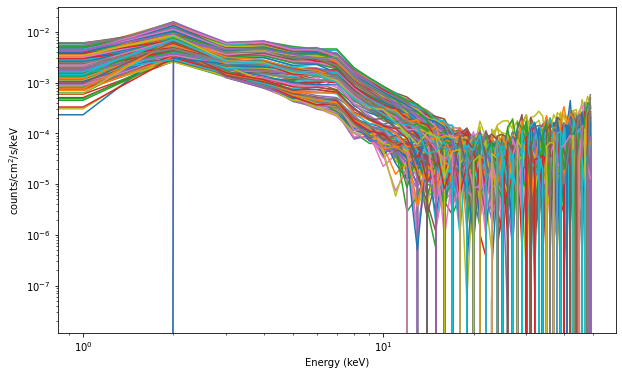

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

for s in dataset:
    ax.plot(xref,s)
ax.set_xlabel('Energy (keV)')
ax.set_ylabel(r'counts/cm$^2$/s/keV')
ax.set_xscale("log")
ax.set_yscale("log")

And now you can put these into your favorite spectral analysis program like [PyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/quick.html) or into an AI/ML analysis following [our lightcurve example](rxte_example_lightcurves.ipynb).

If you prefer to use the Xspec plot routines, you can do so but only using an output file.  It cannot open a window through a notebook running on SciServer.  So here's an example using a GIF output file and then displaying the result in the notebook:

In [9]:
xspec.Plot.splashPage=None
xspec.Plot.device='spectrum.gif/GIF'
xspec.Plot.xLog = True
xspec.Plot.yLog = True
xspec.Plot.background = False
xspec.Plot()
xspec.Plot.device='/null'

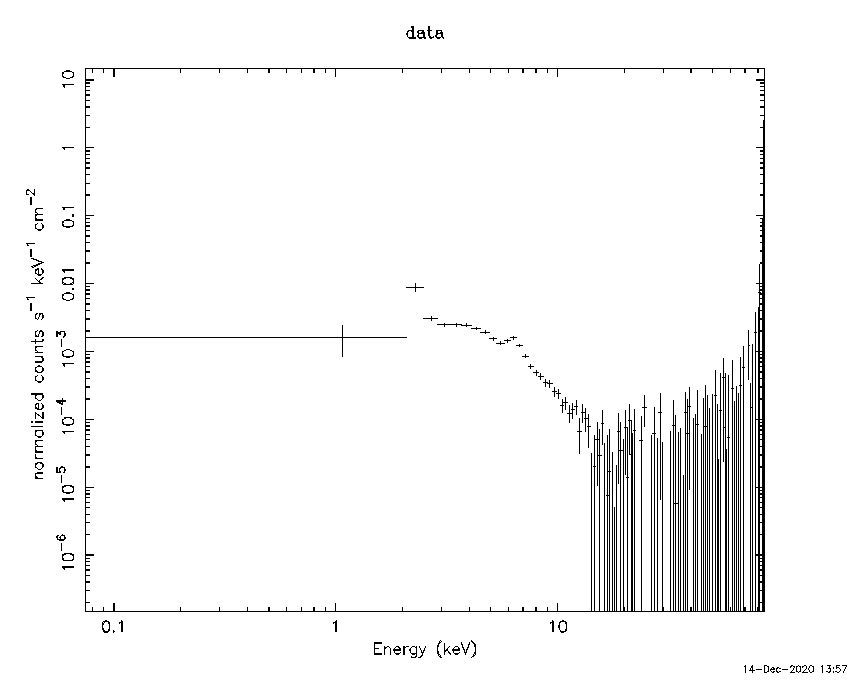

In [10]:
from IPython.display import Image
with open('spectrum.gif','rb') as f:
    display(Image(data=f.read(), format='gif',width=500))